In [1]:
%load_ext autoreload
# %autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv

from extract_field_0 import process_all_laser_files

from __init__ import FourierTransform, InverseFourierTransform, Fourier_filter
from calc_kernnel_johannes import IonProb, IonRate
#from calc_kernel_field_jit import IonRate_johannes as IonRateOldSchool





class AU:
    meter = 5.2917720859e-11 # atomic unit of length in meters
    nm = 5.2917721e-2 # atomic unit of length in nanometres
    second = 2.418884328e-17 # atomic unit of time in seconds
    fs = 2.418884328e-2 # atomic unit of time in femtoseconds
    Joule = 4.359743935e-18 # atomic unit of energy in Joules
    eV = 27.21138383 # atomic unit of energy in electronvolts
    Volts_per_meter = 5.142206313e+11 # atomic unit of electric field in V/m
    Volts_per_Angstrom = 51.42206313 # atomic unit of electric field in V/Angström
    speed_of_light = 137.035999 # vacuum speed of light in atomic units
    Coulomb = 1.60217646e-19 # atomic unit of electric charge in Coulombs
    PW_per_cm2_au = 0.02849451308 # PW/cm^2 in atomic units
AtomicUnits=AU

def Vector_potential(t,lam0, I, cep, FWHM, pi=np.pi, N=8): 
    """" return A(t) for given Full with half maximum and phase with a cos8 envelope  """
    w0=2*pi*137.035999/(lam0/5.2917721e-2)
    A0=np.sqrt(I/1e15*0.02849451308/w0**2)
    tau_injection=pi*FWHM/(4*np.arccos(2**(-1/(2*N))))
    t=np.asarray(t)
    # Field=np.zeros(np.shape(t))
    # cond=(abs(t)<=tau_injection)
    # t=t[cond]
    # Field[cond]=ne.evaluate("cos(pi*t/tau_injection/2)**N*sin(i*w0*t-cep)*A0")
    #Field= cos(pi*t/tau_injection/2)**N*sin(w0*t-cep)*A0  
    Field=np.where(np.abs(t)<=tau_injection,np.cos(pi*t/tau_injection/2)**N*np.sin(w0*t-cep)*A0,0)
    return Field

def Electric_Field(t,lam0, I, cep, FWHM, pi=np.pi, N=8): 
    """" return E(t) for given Full with half maximum and phase with a cos8 envelope  """
    #print('Electric_Field is deprecated, use Vector_potential instead')
    w0=2*pi*137.035999/(lam0/5.2917721e-2)
    A0=np.sqrt(I/1e15*0.02849451308/w0**2)
    tau_injection=pi*FWHM/(4*np.arccos(2**(-1/(2*N))))
    t=np.asarray(t)
    Field= np.where(np.abs(t)<=tau_injection,np.cos(pi*t/tau_injection/2)**N*np.cos(w0*t-cep)*w0-(N/2/tau_injection*pi*np.cos(pi*t/tau_injection/2)**(N-1)*np.sin(pi*t/tau_injection/2)*np.sin(w0*t-cep)),0)
    return -1*Field*A0

def analytical_rate(field, c1, e1, a1, a2, b1, b2, b3, p1, dTi, Ip):
    field=field+1e-20
    term1 = 1 / (2**(1/4) * (8 * e1**2 * field**2 + Ip)**(1/4) * abs(field)**(9/2)+1e-20)
    term2 = np.exp((4 * (np.sqrt(2) * np.sqrt(8 * e1**2 * field**2 + Ip) - 4 * e1 * abs(field)) * 
                    (-4 * e1**2 * field**2 - Ip + np.sqrt(2) * e1 * np.sqrt(8 * e1**2 * field**2 + Ip) * abs(field))) / 
                   (3 * abs(field)))
    term3 = field**2 * np.sqrt(np.pi)
    term4 = (dTi - 4 * e1 + (np.sqrt(2) * np.sqrt(8 * e1**2 * field**2 + Ip)) / abs(field))**-p1
    term5 = (a1 * field**4 + 8 * (-b1 * e1 * field**4 + 16 * a2 * e1**2 * field**6 - 256 * b2 * e1**3 * field**6 + 
                                  1024 * b3 * e1**4 * field**6 + a2 * field**4 * Ip - 24 * b2 * e1 * field**4 * Ip + 
                                  128 * b3 * e1**2 * field**4 * Ip + 2 * b3 * field**2 * Ip**2) - 
             16 * np.sqrt(2) * (-b2 + 8 * b3 * e1) * field**2 * (8 * e1**2 * field**2 + Ip)**(3/2) * abs(field) + 
             2 * np.sqrt(2) * (b1 - 16 * e1 * (a2 + 4 * e1 * (-3 * b2 + 8 * b3 * e1)) * field**2) * 
             np.sqrt(8 * e1**2 * field**2 + Ip) * abs(field)**3)
    
    return term1 * c1 * term2 * term3 * term4 * term5

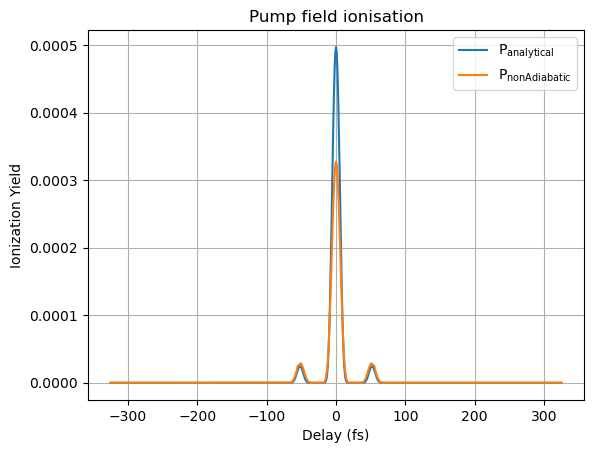

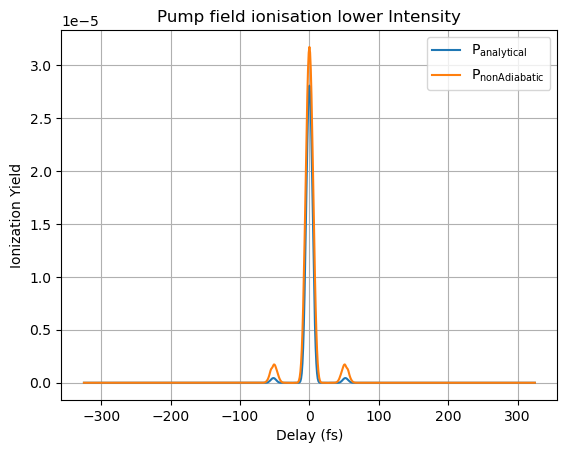

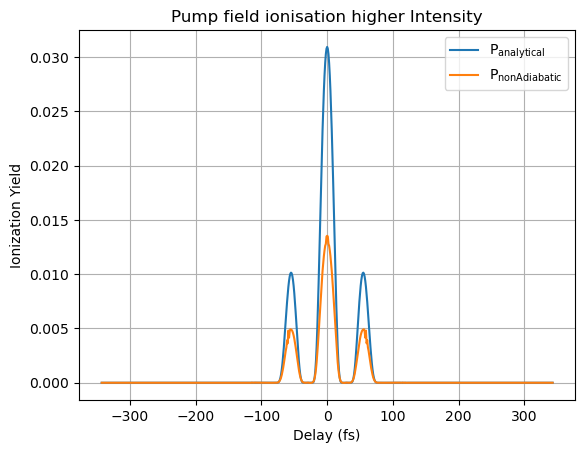

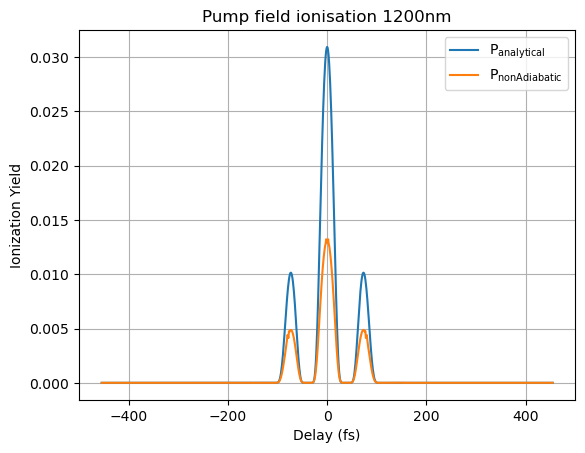

In [5]:
data_1 = pd.read_csv("/home/user/TIPTOE/plot_ion_tau_calc_output_data/ion_rate_QS_NA_data.csv")
data_lower_Int_1 = pd.read_csv("/home/user/TIPTOE/plot_ion_tau_calc_output_data/ion_rate_QS_NA_data_lower_Int.csv")
data_higher_Int_1 = pd.read_csv("/home/user/TIPTOE/plot_ion_tau_calc_output_data/ion_rate_QS_NA_data_higher_Int.csv")
data_1200nm_1 = pd.read_csv("/home/user/TIPTOE/plot_ion_tau_calc_output_data/ion_rate_QS_NA_data_1200nm.csv")

time=np.array(data_1['time'])
time_lower_Int=np.array(data_lower_Int_1['time'])
time_higher_Int=np.array(data_higher_Int_1['time'])
time_1200nm=np.array(data_1200nm_1['time'])

ion_analytical = np.array(data_1['ion_analytical'].values)
ion_nonAdiabatic = np.array(data_1['ion_nonAdiabatic'].values)
ion_analytical_lower_Int = np.array(data_lower_Int_1['ion_analytical'].values)
ion_nonAdiabatic_lower_Int = np.array(data_lower_Int_1['ion_nonAdiabatic'].values)
ion_analytical_higher_Int = np.array(data_higher_Int_1['ion_analytical'].values)
ion_nonAdiabatic_higher_Int = np.array(data_higher_Int_1['ion_nonAdiabatic'].values)
ion_analytical_1200nm = np.array(data_1200nm_1['ion_analytical'].values)
ion_nonAdiabatic_1200nm = np.array(data_1200nm_1['ion_nonAdiabatic'].values)


plt.plot(time, ion_analytical, label=rf'$\mathrm{{P}}_\mathrm{{analytical}}$')
plt.plot(time, ion_nonAdiabatic, label=rf'$\mathrm{{P}}_\mathrm{{nonAdiabatic}}$')
plt.xlabel('Delay (fs)')
plt.ylabel('Ionization Yield')
plt.title('Pump field ionisation')
plt.grid()
plt.legend()
plt.show()
plt.close()

plt.plot(time_lower_Int, ion_analytical_lower_Int, label=rf'$\mathrm{{P}}_\mathrm{{analytical}}$')
plt.plot(time_lower_Int, ion_nonAdiabatic_lower_Int, label=rf'$\mathrm{{P}}_\mathrm{{nonAdiabatic}}$')
plt.ylabel('Ionization Yield')
plt.xlabel('Delay (fs)')
plt.title('Pump field ionisation lower Intensity')
plt.grid()
plt.legend()
plt.show()
plt.close()

plt.plot(time_higher_Int, ion_analytical_higher_Int, label=rf'$\mathrm{{P}}_\mathrm{{analytical}}$')
plt.plot(time_higher_Int, ion_nonAdiabatic_higher_Int, label=rf'$\mathrm{{P}}_\mathrm{{nonAdiabatic}}$')
plt.ylabel('Ionization Yield')
plt.xlabel('Delay (fs)')
plt.title('Pump field ionisation higher Intensity')
plt.grid()
plt.legend()
plt.show()
plt.close()

plt.plot(time_1200nm, ion_analytical_1200nm, label=rf'$\mathrm{{P}}_\mathrm{{analytical}}$')
plt.plot(time_1200nm, ion_nonAdiabatic_1200nm, label=rf'$\mathrm{{P}}_\mathrm{{nonAdiabatic}}$')
plt.ylabel('Ionization Yield')
plt.xlabel('Delay (fs)')
plt.title('Pump field ionisation 1200nm')
plt.grid()
plt.legend()
plt.show()
plt.close()

# plt.plot(delay, ion_y/max(abs(ion_y)), label=rf'$\mathrm{{P}}_\mathrm{{tRecX}}$')
# plt.plot(delay_lower_Int, ion_y_lower_Int/max(abs(ion_y_lower_Int)), label=rf'$\mathrm{{P}}_\mathrm{{tRecX, low}}$')
# plt.plot(delay_higher_Int, ion_y_higher_Int/max(abs(ion_y_higher_Int)), label=rf'$\mathrm{{P}}_\mathrm{{tRecX, high}}$')
# plt.plot(delay_1200nm, ion_y_1200nm/max(abs(ion_y_1200nm)), label=rf'$\mathrm{{P}}_\mathrm{{tRecX, 1200nm}}$')
# plt.xlabel('Delay (fs)')
# plt.ylabel('Ionization Yield')
# plt.title('Ionization yield')
# plt.legend()
# plt.show()
# plt.close()

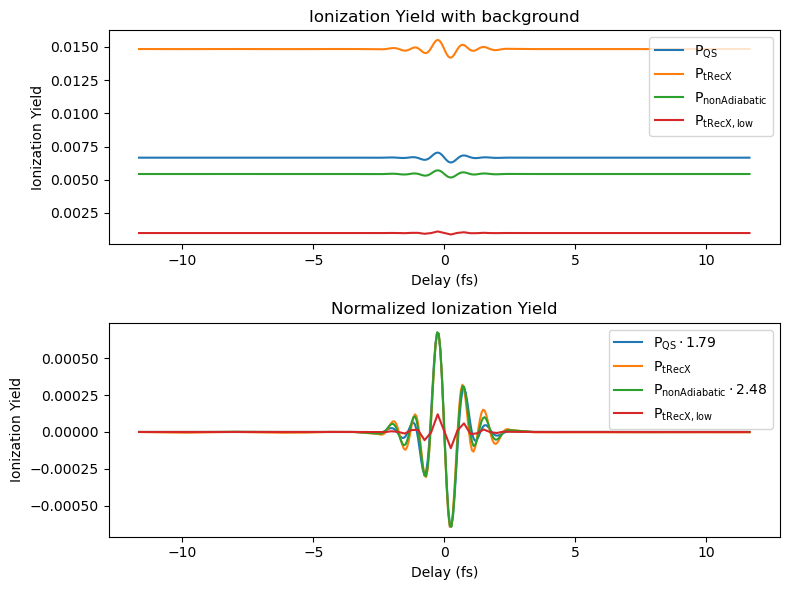

In [19]:
data = pd.read_csv("/home/user/TIPTOE/plot_ion_tau_calc_output_data/ion_prob_QS_NA_data.csv")
data_lower_Int = pd.read_csv("/home/user/TIPTOE/plot_ion_tau_calc_output_data/ion_prob_QS_NA_data_lower_Int.csv")
data_higher_Int = pd.read_csv("/home/user/TIPTOE/plot_ion_tau_calc_output_data/ion_prob_QS_NA_data_higher_Int.csv")
data_1200nm = pd.read_csv("/home/user/TIPTOE/plot_ion_tau_calc_output_data/ion_prob_QS_NA_data_1200nm.csv")

data_2 = pd.read_csv("/home/user/TIPTOE/plot_ion_tau_calc_output_data/ion_rate_QS_NA_data.csv")
data_lower_Int_2 = pd.read_csv("/home/user/TIPTOE/plot_ion_tau_calc_output_data/ion_rate_QS_NA_data_lower_Int.csv")
data_higher_Int_2 = pd.read_csv("/home/user/TIPTOE/plot_ion_tau_calc_output_data/ion_rate_QS_NA_data_higher_Int.csv")
data_1200nm_2 = pd.read_csv("/home/user/TIPTOE/plot_ion_tau_calc_output_data/ion_rate_QS_NA_data_1200nm.csv")

delay=np.array(data['delay'].values)
delay_lower_Int=np.array(data_lower_Int['delay'].values)
delay_higher_Int=np.array(data_higher_Int['delay'].values)
delay_1200nm=np.array(data_1200nm['delay'].values)

ion_QS=np.array(data['ion_QS'].values)
ion_na=np.array(data['ion_NA'].values)
ion_y=np.array(data['ion_y'].values)

ion_QS_lower_Int=np.array(data_lower_Int['ion_QS'].values)
ion_na_lower_Int=np.array(data_lower_Int['ion_NA'].values)
ion_y_lower_Int=np.array(data_lower_Int['ion_y'].values)

ion_QS_higher_Int=np.array(data_higher_Int['ion_QS'].values)
ion_na_higher_Int=np.array(data_higher_Int['ion_NA'].values)
ion_y_higher_Int=np.array(data_higher_Int['ion_y'].values)

ion_QS_1200nm=np.array(data_1200nm['ion_QS'].values)
ion_na_1200nm=np.array(data_1200nm['ion_NA'].values)
ion_y_1200nm=np.array(data_1200nm['ion_y'].values)

time=np.array(data_2['time'].values)
time_lower_Int=np.array(data_lower_Int_2['time'].values)
time_higher_Int=np.array(data_higher_Int_2['time'].values)
time_1200nm=np.array(data_1200nm_2['time'].values)

field_probe_fourier_time=np.array(data_2['field_probe'].values)
field_probe_fourier_time_lower_Int=np.array(data_lower_Int_2['field_probe'].values)
field_probe_fourier_time_higher_Int=np.array(data_higher_Int_2['field_probe'].values)
field_probe_fourier_time_1200nm=np.array(data_1200nm_2['field_probe'].values)





fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

ax1.plot(delay*AU.fs, ion_QS, label=rf'$\mathrm{{P}}_\mathrm{{QS}}$')
ax1.plot(delay*AU.fs, ion_y, label=rf'$\mathrm{{P}}_\mathrm{{tRecX}}$')
ax1.plot(delay*AU.fs, ion_na, label=rf'$\mathrm{{P}}_\mathrm{{nonAdiabatic}}$')
ax1.plot(delay_lower_Int*AU.fs, ion_y_lower_Int, label=rf'$\mathrm{{P}}_\mathrm{{tRecX, low}}$')

ax1.set_ylabel('Ionization Yield')
ax1.set_xlabel('Delay (fs)')
ax1.set_title('Ionization Yield with background')
ax1.legend()

ion_na=ion_na-ion_na[-1]
ion_QS=ion_QS-ion_QS[-1]
ion_y=ion_y-ion_y[-1]
ion_y_lower_Int=ion_y_lower_Int-ion_y_lower_Int[-1]

ax2.plot(delay*AU.fs, ion_QS/max(abs(ion_QS))*max(abs(ion_y)), label=rf'$\mathrm{{P}}_\mathrm{{QS}}\cdot${max(abs(ion_y))/max(abs(ion_QS)):.2f}')
ax2.plot(delay*AU.fs, ion_y, label=rf'$\mathrm{{P}}_\mathrm{{tRecX}}$')
ax2.plot(delay*AU.fs, ion_na/max(abs(ion_na))*max(abs(ion_y)), label=rf'$\mathrm{{P}}_\mathrm{{nonAdiabatic}}\cdot${max(abs(ion_y))/max(abs(ion_na)):.2f}')
ax2.plot(delay_lower_Int*AU.fs, ion_y_lower_Int, label=rf'$\mathrm{{P}}_\mathrm{{tRecX, low}}$')
ax2.set_xlabel('Delay (fs)')
ax2.set_ylabel('Ionization Yield')
ax2.legend()
ax2.set_title('Normalized Ionization Yield')

plt.tight_layout()
plt.show()
plt.close()

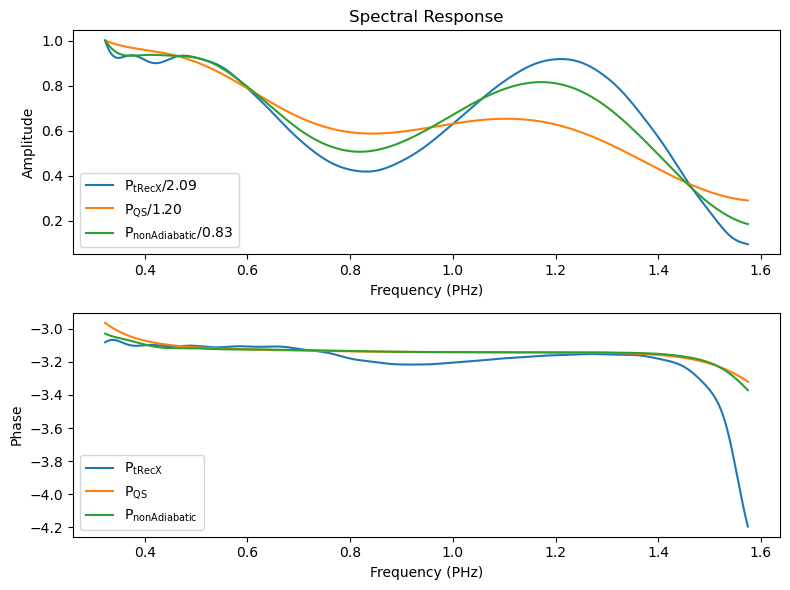

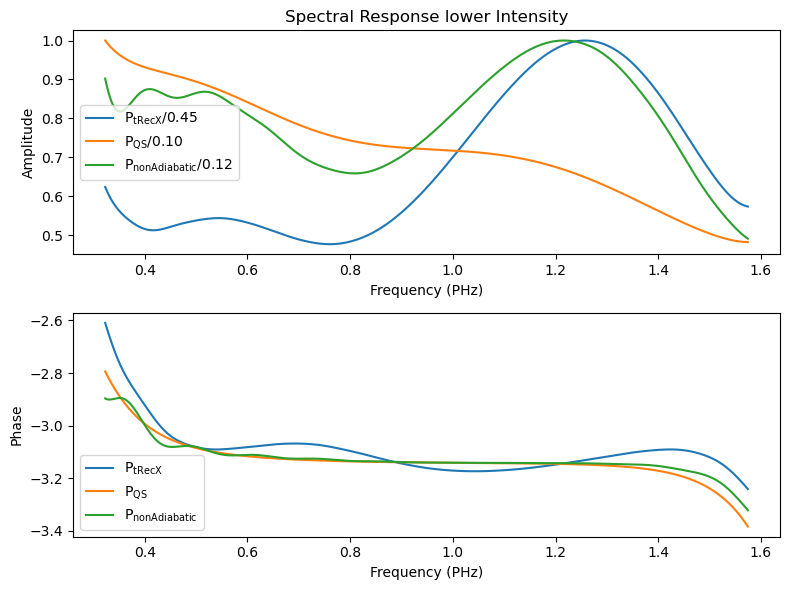

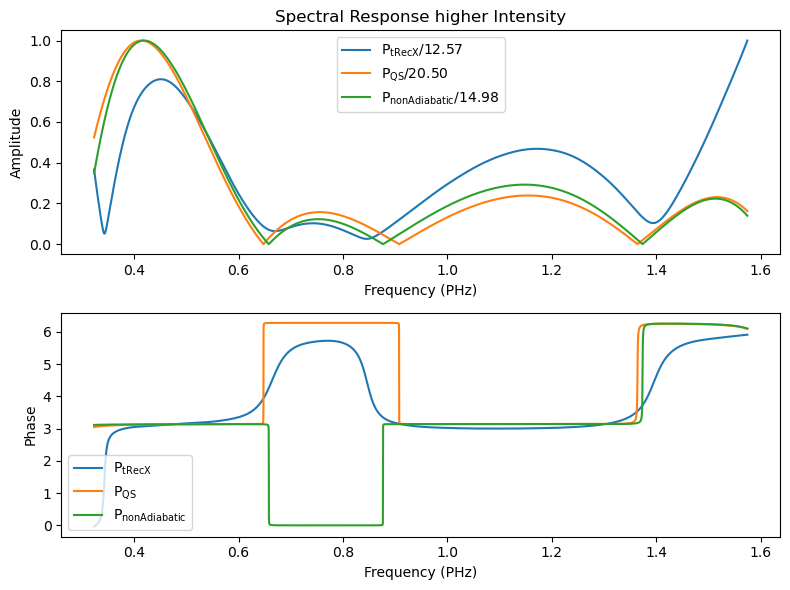

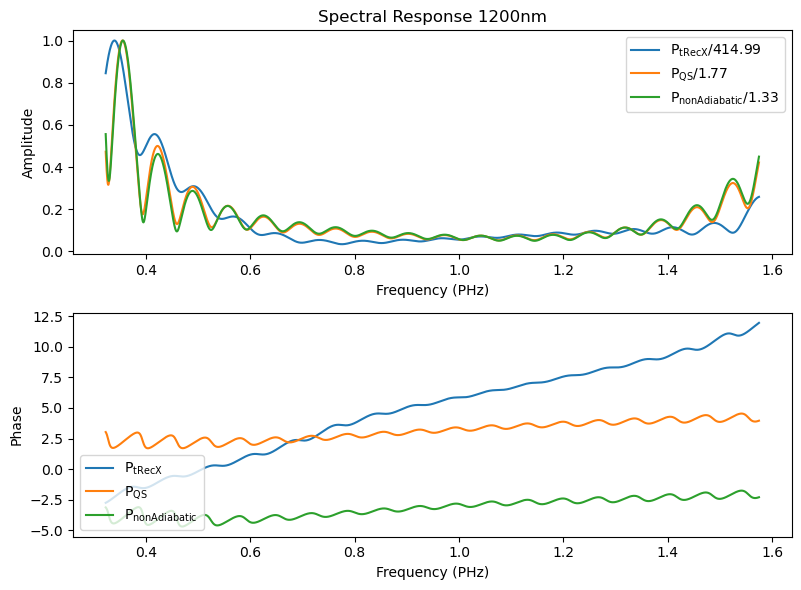

In [18]:
ion_na=ion_na-ion_na[-1]
ion_QS=ion_QS-ion_QS[-1] 
ion_y=ion_y-ion_y[-1]

ion_na_lower_Int=ion_na_lower_Int-ion_na_lower_Int[-1]
ion_QS_lower_Int=ion_QS_lower_Int-ion_QS_lower_Int[-1]
ion_y_lower_Int=ion_y_lower_Int-ion_y_lower_Int[-1]

ion_na_higher_Int=ion_na_higher_Int-ion_na_higher_Int[-1]
ion_QS_higher_Int=ion_QS_higher_Int-ion_QS_higher_Int[-1]
ion_y_higher_Int=ion_y_higher_Int-ion_y_higher_Int[-1]

ion_na_1200nm=ion_na_1200nm-ion_na_1200nm[-1]
ion_QS_1200nm=ion_QS_1200nm-ion_QS_1200nm[-1]
ion_y_1200nm=ion_y_1200nm-ion_y_1200nm[-1]


field_probe_fourier, omega = FourierTransform(time*AU.fs, field_probe_fourier_time, t0=0)
field_probe_fourier=field_probe_fourier.flatten()
omega=omega[abs(field_probe_fourier)*20>max(abs(field_probe_fourier))]
omega=omega[omega>0]
omega=np.linspace(omega[0], omega[-1], 5000)
field_probe_fourier = FourierTransform(time*AU.fs, field_probe_fourier_time, omega, t0=0) #???????

field_probe_fourier_lower_Int, omega_lower_Int = FourierTransform(time_lower_Int*AU.fs, field_probe_fourier_time_lower_Int, t0=0)
field_probe_fourier_lower_Int=field_probe_fourier_lower_Int.flatten()
omega_lower_Int=omega_lower_Int[abs(field_probe_fourier_lower_Int)*20>max(abs(field_probe_fourier_lower_Int))]
omega_lower_Int=omega_lower_Int[omega_lower_Int>0]
omega_lower_Int=np.linspace(omega_lower_Int[0], omega_lower_Int[-1], 5000)
field_probe_fourier_lower_Int = FourierTransform(time_lower_Int*AU.fs, field_probe_fourier_time_lower_Int, omega_lower_Int, t0=0) #???????

field_probe_fourier_higher_Int, omega_higher_Int = FourierTransform(time_higher_Int*AU.fs, field_probe_fourier_time_higher_Int, t0=0)
field_probe_fourier_higher_Int=field_probe_fourier_higher_Int.flatten()
omega_higher_Int=omega_higher_Int[abs(field_probe_fourier_higher_Int)*20>max(abs(field_probe_fourier_higher_Int))]
omega_higher_Int=omega_higher_Int[omega_higher_Int>0]
omega_higher_Int=np.linspace(omega_higher_Int[0], omega_higher_Int[-1], 5000)
field_probe_fourier_higher_Int = FourierTransform(time_higher_Int*AU.fs, field_probe_fourier_time_higher_Int, omega_higher_Int, t0=0) #???????

field_probe_fourier_1200nm, omega_1200nm = FourierTransform(time_1200nm*AU.fs, field_probe_fourier_time_1200nm, t0=0)
field_probe_fourier_1200nm=field_probe_fourier_1200nm.flatten()
omega_1200nm=omega_1200nm[abs(field_probe_fourier_1200nm)*20>max(abs(field_probe_fourier_1200nm))]
omega_1200nm=omega_1200nm[omega_1200nm>0]
omega_1200nm=np.linspace(omega_1200nm[0], omega_1200nm[-1], 5000)
field_probe_fourier_1200nm = FourierTransform(time_1200nm*AU.fs, field_probe_fourier_time_1200nm, omega_1200nm, t0=0) #???????


ion_QS_fourier = FourierTransform(delay[::-1]*AU.fs, ion_QS[::-1], omega, t0=0)
ion_y_fourier = FourierTransform(delay[::-1]*AU.fs, ion_y[::-1], omega, t0=0)
ion_nonAdiabatic_fourier = FourierTransform(delay[::-1]*AU.fs, ion_na[::-1], omega, t0=0)

ion_QS_lower_Int_fourier = FourierTransform(delay_lower_Int[::-1]*AU.fs, ion_QS_lower_Int[::-1], omega, t0=0)
ion_y_lower_Int_fourier = FourierTransform(delay_lower_Int[::-1]*AU.fs, ion_y_lower_Int[::-1], omega, t0=0)
ion_nonAdiabatic_lower_Int_fourier = FourierTransform(delay_lower_Int[::-1]*AU.fs, ion_na_lower_Int[::-1], omega, t0=0)

ion_QS_higher_Int_fourier = FourierTransform(delay_higher_Int[::-1]*AU.fs, ion_QS_higher_Int[::-1], omega, t0=0)
ion_y_higher_Int_fourier = FourierTransform(delay_higher_Int[::-1]*AU.fs, ion_y_higher_Int[::-1], omega, t0=0)
ion_nonAdiabatic_higher_Int_fourier = FourierTransform(delay_higher_Int[::-1]*AU.fs, ion_na_higher_Int[::-1], omega, t0=0)

ion_QS_1200nm_fourier = FourierTransform(delay_1200nm[::-1]*AU.fs, ion_QS_1200nm[::-1], omega, t0=0)
ion_y_1200nm_fourier = FourierTransform(delay_1200nm[::-1]*AU.fs, ion_y_1200nm[::-1], omega, t0=0)
ion_nonAdiabatic_1200nm_fourier = FourierTransform(delay_1200nm[::-1]*AU.fs, ion_na_1200nm[::-1], omega, t0=0)

ion_QS_resp=ion_QS_fourier/field_probe_fourier
ion_y_resp=ion_y_fourier/field_probe_fourier
ion_nonAdiabatic_resp=ion_nonAdiabatic_fourier/field_probe_fourier

ion_QS_lower_Int_resp=ion_QS_lower_Int_fourier/field_probe_fourier_lower_Int
ion_y_lower_Int_resp=ion_y_lower_Int_fourier/field_probe_fourier_lower_Int
ion_nonAdiabatic_lower_Int_resp=ion_nonAdiabatic_lower_Int_fourier/field_probe_fourier_lower_Int

ion_QS_higher_Int_resp=ion_QS_higher_Int_fourier/field_probe_fourier_higher_Int
ion_y_higher_Int_resp=ion_y_higher_Int_fourier/field_probe_fourier_higher_Int
ion_nonAdiabatic_higher_Int_resp=ion_nonAdiabatic_higher_Int_fourier/field_probe_fourier_higher_Int

ion_QS_1200nm_resp=ion_QS_1200nm_fourier/field_probe_fourier_1200nm
ion_y_1200nm_resp=ion_y_1200nm_fourier/field_probe_fourier_1200nm
ion_nonAdiabatic_1200nm_resp=ion_nonAdiabatic_1200nm_fourier/field_probe_fourier_1200nm





fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

ax1.plot(omega/2/np.pi, np.abs(ion_y_resp)/np.abs(ion_y_resp).max(), label=rf'$\mathrm{{P}}_\mathrm{{tRecX}}$/{np.abs(ion_y_resp).max():.2f}')
ax1.plot(omega/2/np.pi, np.abs(ion_QS_resp)/np.abs(ion_QS_resp).max(), label=rf'$\mathrm{{P}}_\mathrm{{QS}}$/{np.abs(ion_QS_resp).max():.2f}') 
ax1.plot(omega/2/np.pi, np.abs(ion_nonAdiabatic_resp)/np.abs(ion_nonAdiabatic_resp).max(), label=rf'$\mathrm{{P}}_\mathrm{{nonAdiabatic}}$/{np.abs(ion_nonAdiabatic_resp).max():.2f}')


ax1.set_xlabel('Frequency (PHz)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Spectral Response')
ax1.legend()

ax2.plot(omega/2/np.pi, np.unwrap(np.angle(ion_y_resp)), label=rf'$\mathrm{{P}}_\mathrm{{tRecX}}$')
ax2.plot(omega/2/np.pi, np.unwrap(np.angle(ion_QS_resp)), label=rf'$\mathrm{{P}}_\mathrm{{QS}}$')
ax2.plot(omega/2/np.pi, np.unwrap(np.angle(ion_nonAdiabatic_resp)), label=rf'$\mathrm{{P}}_\mathrm{{nonAdiabatic}}$')

ax2.set_xlabel('Frequency (PHz)')
ax2.set_ylabel('Phase')
ax2.legend(loc='lower left')
fig.tight_layout()
plt.show()
plt.close()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

ax1.plot(omega/2/np.pi, np.abs(ion_y_lower_Int_resp)/np.abs(ion_y_lower_Int_resp).max(), label=rf'$\mathrm{{P}}_\mathrm{{tRecX}}$/{np.abs(ion_y_lower_Int_resp).max():.2f}')
ax1.plot(omega/2/np.pi, np.abs(ion_QS_lower_Int_resp)/np.abs(ion_QS_lower_Int_resp).max(), label=rf'$\mathrm{{P}}_\mathrm{{QS}}$/{np.abs(ion_QS_lower_Int_resp).max():.2f}')
ax1.plot(omega/2/np.pi, np.abs(ion_nonAdiabatic_lower_Int_resp)/np.abs(ion_nonAdiabatic_lower_Int_resp).max(), label=rf'$\mathrm{{P}}_\mathrm{{nonAdiabatic}}$/{np.abs(ion_nonAdiabatic_lower_Int_resp).max():.2f}')
ax1.set_xlabel('Frequency (PHz)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Spectral Response lower Intensity')
ax1.legend()

ax2.plot(omega/2/np.pi, np.unwrap(np.angle(ion_y_lower_Int_resp)), label=rf'$\mathrm{{P}}_\mathrm{{tRecX}}$')
ax2.plot(omega/2/np.pi, np.unwrap(np.angle(ion_QS_lower_Int_resp)), label=rf'$\mathrm{{P}}_\mathrm{{QS}}$')
ax2.plot(omega/2/np.pi, np.unwrap(np.angle(ion_nonAdiabatic_lower_Int_resp)), label=rf'$\mathrm{{P}}_\mathrm{{nonAdiabatic}}$')
ax2.set_xlabel('Frequency (PHz)')
ax2.set_ylabel('Phase')
ax2.legend(loc='lower left')
fig.tight_layout()
plt.show()
plt.close()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

ax1.plot(omega/2/np.pi, np.abs(ion_y_higher_Int_resp)/np.abs(ion_y_higher_Int_resp).max(), label=rf'$\mathrm{{P}}_\mathrm{{tRecX}}$/{np.abs(ion_y_higher_Int_resp).max():.2f}')
ax1.plot(omega/2/np.pi, np.abs(ion_QS_higher_Int_resp)/np.abs(ion_QS_higher_Int_resp).max(), label=rf'$\mathrm{{P}}_\mathrm{{QS}}$/{np.abs(ion_QS_higher_Int_resp).max():.2f}')
ax1.plot(omega/2/np.pi, np.abs(ion_nonAdiabatic_higher_Int_resp)/np.abs(ion_nonAdiabatic_higher_Int_resp).max(), label=rf'$\mathrm{{P}}_\mathrm{{nonAdiabatic}}$/{np.abs(ion_nonAdiabatic_higher_Int_resp).max():.2f}')
ax1.set_xlabel('Frequency (PHz)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Spectral Response higher Intensity')
ax1.legend()

ax2.plot(omega/2/np.pi, np.unwrap(np.angle(ion_y_higher_Int_resp)), label=rf'$\mathrm{{P}}_\mathrm{{tRecX}}$')
ax2.plot(omega/2/np.pi, np.unwrap(np.angle(ion_QS_higher_Int_resp)), label=rf'$\mathrm{{P}}_\mathrm{{QS}}$')
ax2.plot(omega/2/np.pi, np.unwrap(np.angle(ion_nonAdiabatic_higher_Int_resp)), label=rf'$\mathrm{{P}}_\mathrm{{nonAdiabatic}}$')
ax2.set_xlabel('Frequency (PHz)')
ax2.set_ylabel('Phase')
ax2.legend(loc='lower left')
fig.tight_layout()
plt.show()
plt.close()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

ax1.plot(omega/2/np.pi, np.abs(ion_y_1200nm_resp)/np.abs(ion_y_1200nm_resp).max(), label=rf'$\mathrm{{P}}_\mathrm{{tRecX}}$/{np.abs(ion_y_1200nm_resp).max():.2f}')
ax1.plot(omega/2/np.pi, np.abs(ion_QS_1200nm_resp)/np.abs(ion_QS_1200nm_resp).max(), label=rf'$\mathrm{{P}}_\mathrm{{QS}}$/{np.abs(ion_QS_1200nm_resp).max():.2f}')
ax1.plot(omega/2/np.pi, np.abs(ion_nonAdiabatic_1200nm_resp)/np.abs(ion_nonAdiabatic_1200nm_resp).max(), label=rf'$\mathrm{{P}}_\mathrm{{nonAdiabatic}}$/{np.abs(ion_nonAdiabatic_1200nm_resp).max():.2f}')
ax1.set_xlabel('Frequency (PHz)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Spectral Response 1200nm')
ax1.legend()

ax2.plot(omega/2/np.pi, np.unwrap(np.angle(ion_y_1200nm_resp)), label=rf'$\mathrm{{P}}_\mathrm{{tRecX}}$')
ax2.plot(omega/2/np.pi, np.unwrap(np.angle(ion_QS_1200nm_resp)), label=rf'$\mathrm{{P}}_\mathrm{{QS}}$')
ax2.plot(omega/2/np.pi, np.unwrap(np.angle(ion_nonAdiabatic_1200nm_resp)), label=rf'$\mathrm{{P}}_\mathrm{{nonAdiabatic}}$')
ax2.set_xlabel('Frequency (PHz)')
ax2.set_ylabel('Phase')
ax2.legend(loc='lower left')
fig.tight_layout()
plt.show()
plt.close()




# plt.plot(omega/2/np.pi, np.abs(ion_y_fourier)/np.abs(ion_y_fourier).max(), label='P_tRecX')
# plt.plot(omega/2/np.pi, np.abs(ion_QS_fourier)/np.abs(ion_QS_fourier).max(), label='P_QS')

#plt.plot(time, np.abs(field_probe_fourier[0][:1001]))
#plt.plot(np.abs(field_probe_fourier[1]), np.abs(field_probe_fourier[0]))

# plt.plot(time, np.abs(ion_QS_fourier[0][:1001]))
# plt.show()
# plt.close()